In [145]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import r2_score

# XGBoost import
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import pickle



In [161]:
df= pd.read_csv('data/price/price_baechoo.csv')
# df 구분 인덱스로 설정
df.set_index('구분', inplace=True)

# 평균 컬럼 가격 컬럼으로 변경
df.rename(columns={'평균':'가격'}, inplace=True)

df

,가격
구분,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-12-14,5430.5
2022-12-15,5430.5
2022-12-16,5304.0


In [162]:
# train, test 데이터 분리 (train: 2000부터 2022-10, test: 2022-11)
df_train = df.loc['2000':'2022-11']
df_test = df.loc['2022-11':'2022-12']

In [163]:
df_test

,가격
구분,
2022-11-01,7350.0
2022-11-02,6835.5
2022-11-03,7142.0
2022-11-04,7381.5
2022-11-07,7330.0
2022-11-08,7193.5
2022-11-09,6760.0
2022-11-10,6952.0
2022-11-11,6992.0


In [167]:
window_size= 5
num_list= []
for i in range(1, int(len(df_train)/window_size)+1):
    num_list.append(i*window_size)

candle_df= pd.DataFrame(columns=['시가', '고가', '저가', '종가', '날짜'])
for i in range(len(num_list)):
    candle_df.loc[i, '시가']= df_train.iloc[num_list[i]-window_size, 0]
    candle_df.loc[i, '고가']= df_train.iloc[num_list[i]-window_size:num_list[i], 0].max()
    candle_df.loc[i, '저가']= df_train.iloc[num_list[i]-window_size:num_list[i], 0].min()
    candle_df.loc[i, '종가']= df_train.iloc[num_list[i]-1, 0]
    # 종가에 해당하는 날짜를 인덱스로 넣어
    candle_df.loc[i, '날짜']= df_train.index[num_list[i]-1]

# shift(1) "종가_shift" 컬럼 생성
candle_df['종가_shift']= candle_df['종가'].shift(1)


# candle_df 날짜 인덱스로 설정
candle_df.set_index('날짜', inplace=True)

# 결측치 제거
candle_df.dropna(inplace=True)

candle_df


,시가,고가,저가,종가,종가_shift
날짜,,,,,
2000-01-07,5600.0,5700.0,5600.0,5670.0,NaN
2000-01-13,5770.0,5790.0,5630.0,5630.0,5670.0
2000-01-19,5630.0,5650.0,5630.0,5650.0,5630.0
2000-01-25,5850.0,5910.0,5850.0,5910.0,5650.0
2000-01-31,5930.0,6620.0,5930.0,6620.0,5910.0
...,...,...,...,...,...
2022-09-29,30250.0,30250.0,23520.0,23520.0,33030.0
2022-10-07,22620.0,23500.0,17600.0,17600.0,23520.0
2022-10-17,14740.0,14740.0,10623.0,10623.0,17600.0


In [132]:
feature= candle_df[['시가', '고가', '저가','종가']]
target= candle_df[['종가']]

scaler= StandardScaler()
scaler1= StandardScaler()

feature_sc= scaler.fit_transform(feature)
target_sc= scaler1.fit_transform(target)

feature_sc= pd.DataFrame(feature_sc, columns=feature.columns, index=feature.index)
target_sc= pd.DataFrame(target_sc, columns=target.columns, index=target.index)

feature_sc

,시가,고가,저가
날짜,,,
2000-01-07,-0.258146,-0.306002,-0.180682
2000-01-13,-0.217012,-0.285960,-0.172736
2000-01-19,-0.250887,-0.317136,-0.172736
2000-01-25,-0.197654,-0.259238,-0.114470
2000-01-31,-0.178297,-0.101133,-0.093282
...,...,...,...
2022-09-29,5.706327,5.160875,4.565383
2022-10-07,3.860123,3.657763,2.997487
2022-10-17,1.953427,1.707056,1.149647


In [133]:
#  train, test 데이터 분리
train_X, test_X, train_y, test_y= train_test_split(feature_sc, target_sc, test_size=0.2, shuffle=False)

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (937, 3) (937, 1)
테스트 데이터의 크기 : (235, 3) (235, 1)


In [139]:
# Xgboost 모델
xgb_model= XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
xgb_model.fit(train_X, train_y, early_stopping_rounds=100, eval_set=[(test_X, test_y)], verbose=False)

# 예측
pred= xgb_model.predict(test_X)

c:\Users\LG-PC\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


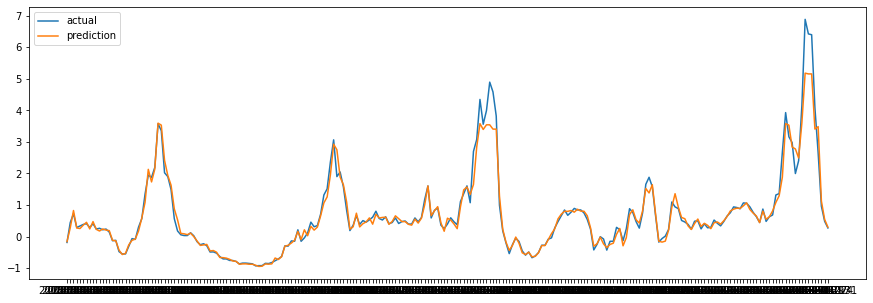

In [143]:
# 시각화
plt.figure(figsize=(15, 5))
plt.plot(test_y, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()




In [144]:
# 성능 평가
print('MSE: ', mean_squared_error(test_y, pred))
print('MAE: ', mean_absolute_error(test_y, pred))
print('R2: ', r2_score(test_y, pred))

MSE:  0.07616210976317254
MAE:  0.1353719418877316
R2:  0.9546002085201433


In [148]:
# 모델 저장
pickle.dump(xgb_model, open('model/price_candle.pkl', 'wb'))

Make new data

In [151]:
window_size= 5
num_list= []
for i in range(1, int(len(df_test)/window_size)+1):
    num_list.append(i*window_size)

candle_test_df= pd.DataFrame(columns=['시가', '고가', '저가', '종가', '날짜'])
for i in range(len(num_list)):
    candle_test_df.loc[i, '시가']= df_test.iloc[num_list[i]-window_size, 0]
    candle_test_df.loc[i, '고가']= df_test.iloc[num_list[i]-window_size:num_list[i], 0].max()
    candle_test_df.loc[i, '저가']= df_test.iloc[num_list[i]-window_size:num_list[i], 0].min()
    candle_test_df.loc[i, '종가']= df_test.iloc[num_list[i]-1, 0]
    # 종가에 해당하는 날짜를 인덱스로 넣어
    candle_test_df.loc[i, '날짜']= df_test.index[num_list[i]-1]

# candle_test_df 날짜 인덱스로 설정
candle_test_df.set_index('날짜', inplace=True)

candle_test_df


,시가,고가,저가,종가
날짜,,,,
2022-11-07,7350.0,7381.5,6835.5,7330.0
2022-11-14,7193.5,7193.5,6724.0,6724.0
2022-11-21,6684.0,7018.0,6300.0,6300.0
2022-11-28,6260.0,6260.0,5664.0,5664.0


In [152]:
feature= candle_test_df[['시가', '고가', '저가']]
target= candle_test_df[['종가']]

scaler= StandardScaler()
scaler1= StandardScaler()

feature_sc= scaler.fit_transform(feature)
target_sc= scaler1.fit_transform(target)

feature_sc= pd.DataFrame(feature_sc, columns=feature.columns, index=feature.index)
target_sc= pd.DataFrame(target_sc, columns=target.columns, index=target.index)

feature_sc

,시가,고가,저가
날짜,,,
2022-11-07,1.110318,0.982077,0.989210
2022-11-14,0.746888,0.540641,0.746599
2022-11-21,-0.436290,0.128556,-0.175974
2022-11-28,-1.420916,-1.651274,-1.559835


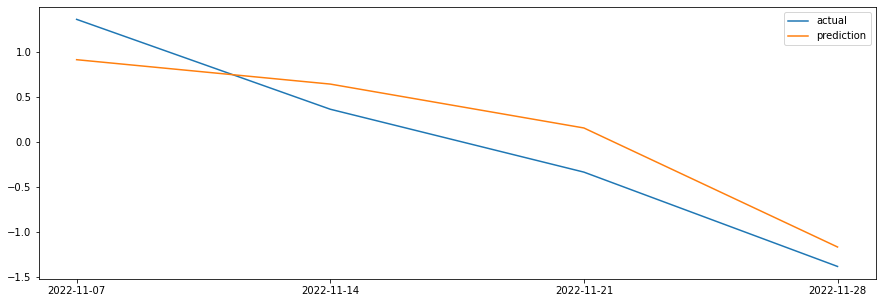

In [153]:
# 모델 불러오기
model= pickle.load(open('model/price_candle.pkl', 'rb'))

# model을 사용하여 df_test 예측
pred= model.predict(feature_sc)

# 시각화
plt.figure(figsize=(15, 5))
plt.plot(target_sc, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

